In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.train_val_test import setup_seed
import torch

SEED = setup_seed()

rna_path = "data/rna.csv"
pam50 = "data/pam50_labels.csv"

if not os.path.isfile(rna_path):
    # Create rna file
    metabric_path = "data/METABRIC_CLIN_GE_CNA.csv"
    complete_data = pd.read_csv(metabric_path, index_col=None, header=0, low_memory=False)
    complete_data = complete_data.drop(
        complete_data[complete_data["Pam50Subtype"] == "?"].index
    )

    rna = complete_data.filter(["METABRIC_ID"]+[col for col in complete_data.columns if col.startswith("GE_")])
    rna = rna.set_index("METABRIC_ID")
    rna = (rna-rna.min())/(rna.max()-rna.min())
    
    rna.to_csv(rna_path)
else:
    # Read rna file
    rna = pd.read_csv(rna_path, index_col=0)

pam50_labels = pd.read_csv(pam50, index_col=0)
mask_test = np.genfromtxt("data/mask_test.csv", delimiter=",", dtype=bool)
pam50_labels_train = pam50_labels["Pam50Subtype"][~mask_test]
rna_train = rna[~mask_test]
rna_train.shape

(1579, 1000)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class RNA(Dataset):

    def __init__(self, rna):
        """
        Arguments:
            rna: RNA numpy array, masked
        """
        # Filter RNA
        self.rna = torch.tensor(rna.values, dtype=torch.float32)
        self.rna_num_features = self.rna.size()[1]

    def __len__(self):
        return len(self.rna)

    def __getitem__(self, idx):
        return self.rna[idx]

In [45]:
import torch.nn as nn


class VAE(nn.Module):
    def __init__(
        self,
        layers,
        beta=0.000020,
        activation_fn=nn.Sigmoid(),
        d_p=0,
        loss_fn=nn.MSELoss(reduction="mean"),
    ):
        super().__init__()

        self.n_layers = len(layers)
        self.activation_fn = activation_fn
        self.loss_fn = loss_fn
        self.beta = beta

        # Encoder
        self.encoders = nn.ModuleList()
        for i in range(len(layers)):
            self.encoders.append(
                nn.Sequential(
                    nn.BatchNorm1d(layers[i][0]),
                    nn.Dropout(p=d_p),
                    nn.Linear(layers[i][0], layers[i][1]),
                    self.activation_fn,
                )
            )

        self.encoder_mean = nn.Linear(layers[-1][1], layers[-1][1])
        self.encoder_log_var = nn.Linear(layers[-1][1], layers[-1][1])

        # Decoder
        self.decoders = nn.ModuleList()
        for i in range(len(layers)):
            self.decoders.append(
                nn.Sequential(
                    nn.Linear(layers[-1 - i][1], layers[-1 - i][0]),
                )
            )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Xavier uniform model initialisation
        @source https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def reparameterize(self, mean, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mean)

        return mean

    def forward(self, x):
        # Encoder
        for i in range(self.n_layers):
            x = self.encoders[i](x)

        latent_mean = self.encoder_mean(x)
        latent_log_var = self.encoder_log_var(x)

        z = self.reparameterize(latent_mean, latent_log_var)
        reconstructed = z
        # Decoder
        for i in range(self.n_layers):
            reconstructed = self.decoders[i](reconstructed)

        return reconstructed, latent_mean, latent_log_var, z

    def forward_pass(self, x):
        reconstructed, latent_mean, latent_log_var, z = self.forward(x)

        reconstruction_loss = self.loss_fn(x, reconstructed)
        KLD = -0.5 * torch.mean(
            1 + latent_log_var - latent_mean.pow(2) - latent_log_var.exp()
        )
        
        loss = reconstruction_loss + self.beta * KLD

        return loss, z

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_VAE(model, dataloader, optimizer):
    model.train()
    loss_sum = 0.0
    
    for batch_idx, x in enumerate(dataloader):
        x = x.to(DEVICE)
         
        loss, _ = model.forward_pass(x)
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_sum / len(dataloader)

@torch.no_grad()
def validate_VAE(model, dataloader):
    model.eval()
    loss_sum = 0.0

    for batch_idx, x in enumerate(dataloader):
        x = x.to(DEVICE)
        loss, _ = model.forward_pass(x)
        loss_sum += loss.item()

    return loss_sum / len(dataloader)

from sklearn.manifold import TSNE
import seaborn as sns

@torch.no_grad()
def evaluate_VAE(model, x, pam50_labels):
    model.eval()
    x = x.to(DEVICE)
    loss, z = model.forward_pass(x)
    
    tsne = TSNE(random_state=SEED)
    z_tsne = tsne.fit_transform(z.cpu().numpy())

    print("T-SNE KL Divergence: ", tsne.kl_divergence_)
    sns.scatterplot(x=z_tsne[:, 0], y=z_tsne[:, 1], hue=pam50_labels)
    plt.show()


In [29]:
import optuna
from sklearn.model_selection import StratifiedKFold
from optuna.samplers import TPESampler

N_TRIALS = 100
TIMEOUT = 120 * 60  # in seconds

N_SPLITS = 3
EPOCHS = 50
MAX_LATENT = 256
INPUT_DIM = 1000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_activation_fn(trial, activation_functions=None):
    if not activation_functions:
        activation_functions = {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "elu": nn.ELU(),
            "leakyrelu": nn.LeakyReLU(0.2),
        }

    activation = trial.suggest_categorical(
        "activation", list(activation_functions.keys())
    )
    return activation_functions[activation]


def define_model_VAE(trial, input_dim):
    max_hidden_channels = input_dim
    min_hidden_channels = 1
    max_latent_space = MAX_LATENT

    n_layers = trial.suggest_int("n_layers", 0, 4)
    d_layer = trial.suggest_int("d_layer", 0, 8)
    d_layer = d_layer / 10

    beta = trial.suggest_float("beta", 1e-6, 1, log=True)

    activation_fn = get_activation_fn(trial)

    layers = []
    for i in range(n_layers):
        hidden_channels = trial.suggest_int(
            f"n_units_l{i}",
            min_hidden_channels,
            max_hidden_channels,
        )

        layers.append((max_hidden_channels, hidden_channels))
        max_hidden_channels = hidden_channels

    latet_dim = trial.suggest_int(
        "n_units_latent", 1, min(max_hidden_channels, max_latent_space)
    )
    layers.append((max_hidden_channels, latet_dim))
    return layers, beta, activation_fn, d_layer


def objective(trial):
    bs = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    wd = trial.suggest_float("weight_decay", 1e-5, 5e-3, log=True)
    layers, beta, activation_fn, d_layer = define_model_VAE(trial, INPUT_DIM)

    val_loss_sum = 0.0

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=False)
    SPLITS = skf.split(rna_train, pam50_labels_train)

    for i, (train_index, test_index) in enumerate(SPLITS):
        model = VAE(layers, beta, activation_fn, d_layer).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        dateset_train = RNA(rna.iloc[train_index])
        loader_train = DataLoader(dateset_train, batch_size=bs, shuffle=True)

        dataset_val = RNA(rna.iloc[test_index])
        loader_val = DataLoader(dataset_val, batch_size=bs, shuffle=True)

        val_loss_best = float("inf")
        for epoch in range(0, EPOCHS):
            train_loss = train_VAE(model, loader_train, optimizer)
            val_loss = validate_VAE(model, loader_val)

            if val_loss_best > val_loss:
                val_loss_best = val_loss

        val_loss_sum += val_loss_best

        trial.report(val_loss_best, i)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss_sum


study_name = "rnaVAE_cv_study"
storage_path = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    direction="minimize",
    study_name=study_name,
    storage=storage_path,
    sampler=TPESampler(seed=SEED),
    load_if_exists=True,
)
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [
    t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE
]

print("Study statistics: ")
print("\tN finished trials: ", len(study.trials))
print("\tN pruned trials: ", len(pruned_trials))
print("\tN completed trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("\tVal loss: ", trial.value)

print("\tParams: ")
for key, value in trial.params.items():
    print(f"\t\t{key}: {value}")

[I 2023-12-05 20:00:53,865] Using an existing study with name 'rnaVAE_cv_study' instead of creating a new one.


0.8042426109313965 0.23677299916744232 1.1352144742707369e-06
0.6881902813911438 0.22543664276599884 1.0808620104439411e-06
0.6611660718917847 0.21783049404621124 1.044394127068217e-06
0.5793121457099915 0.2071058452129364 9.929745115300677e-07
0.5443471670150757 0.20208759605884552 9.689143818055962e-07
0.48424032330513 0.20236197113990784 9.702298804667459e-07
0.4958127737045288 0.19824980199337006 9.50513975561145e-07
0.4502892792224884 0.19977512955665588 9.578271993406083e-07
0.43567705154418945 0.20123045146465302 9.648047791342964e-07
0.3902997374534607 0.20587719976902008 9.870837381032623e-07
0.3800640404224396 0.20944906771183014 1.0042091544434681e-06
0.33792683482170105 0.21309800446033478 1.0217040792328925e-06
0.34600019454956055 0.2167252153158188 1.0390948386474212e-06
0.311436265707016 0.22053858637809753 1.0573781481501344e-06
0.311801552772522 0.2282973676919937 1.0945778325787102e-06
0.3002704679965973 0.23298171162605286 1.1170370447992963e-06
0.2944132089614868 0.

[I 2023-12-05 20:00:54,622] Trial 543 pruned. 


0.08926651626825333 0.46946895122528076 2.2508814371808862e-06
0.08513933420181274 0.4734046459197998 2.26975123060851e-06
0.07968132197856903 0.4791036546230316 2.2970752801903983e-06
0.08071749657392502 0.4804486334323883 2.3035238170478014e-06
0.018795281648635864 0.47548845410346985 2.279742104652527e-06
0.02013375610113144 0.4705973267555237 2.2562914638260222e-06
0.02365613356232643 0.4838290512561798 2.3197313206742477e-06
0.02049182541668415 0.4748978018760681 2.2769102067580692e-06
0.020019756630063057 0.48286688327789307 2.315118180580269e-06
0.02034475840628147 0.4788171350955963 2.2957015546564503e-06
0.01855289936065674 0.46824440360069275 2.245010310858399e-06
0.01956949383020401 0.49106332659721375 2.354416247194074e-06
0.022675173357129097 0.49158772826194763 2.3569305049947135e-06
0.022348348051309586 0.4888177812099457 2.3436499198036105e-06
0.01972469501197338 0.4837234318256378 2.319224925490941e-06
0.02093326300382614 0.4760722517967224 2.282541138299761e-06
0.0199

In [67]:
import time
from torch_geometric.logging import log
from utils.train_val_test import Early_Stopping
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 200

model = VAE([(1000,600),(600,100)], 0.5).to(DEVICE)
lr =  0.00035
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00045)

early_stopping = Early_Stopping(25, mode="minimize")

dateset_train = RNA(rna_train)
loader_train = DataLoader(dateset_train, batch_size=16, shuffle=True)

dataset_val = RNA(rna.iloc[mask_test])
loader_val = DataLoader(dataset_val, batch_size=16, shuffle=True)


for epoch in range(0, EPOCHS):
    start = time.time()
    train_loss = train_VAE(model, loader_train, optimizer)
    val_loss = validate_VAE(model, loader_val)
    
    if epoch % 20 == 0:
        log(
            Epoch=epoch,
            Time=(time.time() - start),
            Train=train_loss,
            Val=val_loss,
        )


    if early_stopping.check(val_loss, model):
        print(f"Early stopped at epoch: {epoch}, Best Val: {early_stopping.best_loss:.4f}")
        model = early_stopping.best_model
        torch.save(model.state_dict(), "rnaVAE.pth")
        break

Epoch: 000, Time: 0.3431, Train: 0.1779, Val: 0.0454
Epoch: 020, Time: 0.2473, Train: 0.0154, Val: 0.0152
Early stopped at epoch: 34, Best Val: 0.0151


T-SNE KL Divergence:  1.0615618228912354


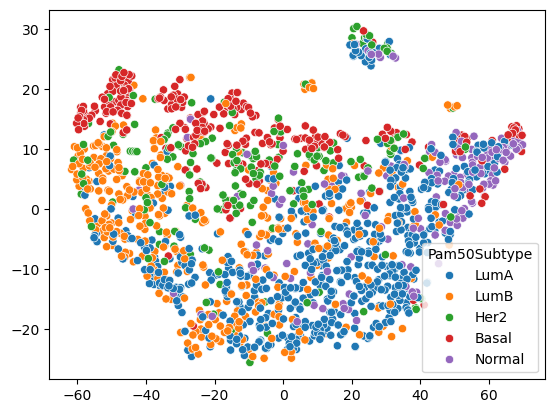

In [68]:
evaluate_VAE(model, dateset_train.rna, pam50_labels_train)